In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import os
import time
from datetime import datetime
import zipfile

tf.__version__

'2.0.0'

In [2]:
#Cifar10 Dataset

data = keras.datasets.cifar10

In [3]:
(train_images, train_labels), (test_images, test_labels) = data.load_data()

In [4]:
#normalizing images

train_images = train_images/255.0
test_images = test_images/255.0

In [5]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [6]:
#converting rgb images to grayscale images to reduce processing time.

def gray_img(images):
    images_grayscale = np.zeros(images.shape[:-1])
    for i in range(0,images.shape[0]):
        images_grayscale[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        
    return images_grayscale

In [7]:
train_images = gray_img(train_images)
test_images = gray_img(test_images)

In [8]:
train_images.shape

(50000, 32, 32)

# Base Model for Cifar-10 Dataset

In [9]:
# CNN model

model = keras.Sequential()
model.add(keras.Input(shape = (32,32)))
model.add(keras.layers.Reshape(target_shape = (32,32,1)))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(
  train_images,
  train_labels,
  epochs=8,
  validation_split=0.1,
)

Train on 45000 samples, validate on 5000 samples
Epoch 1/8
45000/45000 [==============================] - 93s 2ms/sample - loss: 1.6318 - accuracy: 0.4138 - val_loss: 1.3175 - val_accuracy: 0.5304
Epoch 2/8
45000/45000 [==============================] - 77s 2ms/sample - loss: 1.2333 - accuracy: 0.5644 - val_loss: 1.1129 - val_accuracy: 0.6048
Epoch 3/8
45000/45000 [==============================] - 83s 2ms/sample - loss: 1.0382 - accuracy: 0.6358 - val_loss: 0.9931 - val_accuracy: 0.6530
Epoch 4/8
45000/45000 [==============================] - 91s 2ms/sample - loss: 0.9190 - accuracy: 0.6782 - val_loss: 0.9281 - val_accuracy: 0.6770
Epoch 5/8
45000/45000 [==============================] - 89s 2ms/sample - loss: 0.8289 - accuracy: 0.7114 - val_loss: 0.8909 - val_accuracy: 0.6950
Epoch 6/8
45000/45000 [==============================] - 75s 2ms/sample - loss: 0.7493 - accuracy: 0.7361 - val_loss: 0.9153 - val_accuracy: 0.6868
Epoch 7/8
45000/45000 [==============================] - 76s 2m

In [12]:
def factors(model , model_name , zip_name):
    start = datetime.now()
    _, model_accuracy = model.evaluate(
        test_images, test_labels, verbose=0)
    end = datetime.now()
    
    t = end-start
    
    model.save(model_name)
    
    size_without_zip = os.path.getsize(model_name)
    
    size_with_zip = get_gzipped_model_size(model_name , zip_name)
    
    return t.total_seconds() , model_accuracy, size_without_zip , size_with_zip

In [13]:
def get_gzipped_model_size(file , zip_name):
    with zipfile.ZipFile(zip_name, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
        
    return os.path.getsize(zip_name)

In [14]:
time_1  , accuracy_1 ,size_without_zip_1 ,size_with_zip_1 = factors(model , 'Base Model.h5' ,'Base Model.zip')

name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')

Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


# Method - 1) Using Tensorflow model optimization Kit for model pruning and compressing

In [15]:
# tensorflow model optimization kit

!pip install -q tensorflow-model-optimization

You should consider upgrading via the 'c:\users\hitesh khatana\anaconda3\python.exe -m pip install --upgrade pip' command.


In [16]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# (A) Pruning Whole network with 80% sparsity

In [17]:
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
# Define model for pruning.

model_without_pruning = keras.models.load_model('Base Model.h5')
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model_without_pruning,**pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

model_for_pruning.summary()

W0808 14:55:30.868468  5380 deprecation.py:323] From C:\Users\Hitesh khatana\Anaconda3\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:220: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_reshape  (None, 32, 32, 1)         1         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 30, 30, 32)        610       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 15, 15, 32)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 13, 13, 64)        36930     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 6, 6, 64)          1         
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 4, 4, 128)         147586    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 2, 2, 128)         1

In [18]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/2
45000/45000 [==============================] - 74s 2ms/sample - loss: 1.8117 - accuracy: 0.6636 - val_loss: 1.8010 - val_accuracy: 0.6746
Epoch 2/2
45000/45000 [==============================] - 63s 1ms/sample - loss: 1.7577 - accuracy: 0.7186 - val_loss: 1.7796 - val_accuracy: 0.6910


In [24]:
time_2  , accuracy_2 ,size_without_zip_2 ,size_with_zip_2 = factors(model_for_pruning , 'Model Pruned.h5' ,'Model Pruned.zip')

In [25]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


Accuracy of pruned model is :68.07 %
Size of pruned model without Zip is : 4220952 Bytes
Size of pruned model with Zip is : 1473916 Bytes
Time taken for evaluating pruned model is : 4.850215 sec




# Model stripped for compressing Size of model

In [20]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

model_for_export.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
time_3  , accuracy_3 ,size_without_zip_3 ,size_with_zip_3 = factors(model_for_export , 'Model stripped.h5' ,'Model Stripped.zip')

In [26]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


Accuracy of pruned model is :68.07 %
Size of pruned model without Zip is : 4220952 Bytes
Size of pruned model with Zip is : 1473916 Bytes
Time taken for evaluating pruned model is : 4.850215 sec


Accuracy of striped model is :68.07 %
Size of striped model without Zip is : 1065872 Bytes
Size of striped model with Zip is : 309412 Bytes
Time taken for evaluating striped model is : 5.474857 sec




# (B) Pruning only Dense layers 

In [27]:
def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer , **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_dense_layer_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

model_for_dense_layer_pruning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0

In [28]:
model_for_dense_layer_pruning.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
time_4  , accuracy_4 ,size_without_zip_4 ,size_with_zip_4 = factors(model_for_dense_layer_pruning , 'Dense layers pruned.h5' ,'Dense layers pruned.zip')

In [30]:
name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

Accuracy of dense layer pruned model is :69.27 %
Size of dense layer pruned model without Zip is : 1733836 Bytes
Size of dense layer pruned model with Zip is : 967308 Bytes
Time taken for evaluating dense layer pruned model is : 4.633344 sec




In [31]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


Accuracy of pruned model is :68.07 %
Size of pruned model without Zip is : 4220952 Bytes
Size of pruned model with Zip is : 1473916 Bytes
Time taken for evaluating pruned model is : 4.850215 sec


Accuracy of striped model is :68.07 %
Size of striped model without Zip is : 1065872 Bytes
Size of striped model with Zip is : 309412 Bytes
Time taken for evaluating striped model is : 5.474857 sec


Accuracy of dense layer pruned model is :69.27 %
Size of dense layer pruned model without Zip is : 1733836 Bytes
Size of dense layer pruned model with Zip is : 967308 Bytes
Time taken for evaluating dense layer pruned model is : 4.633344 sec




# Model stripped to compress the size

In [32]:
model_stripped_pruned_denselayer = tfmot.sparsity.keras.strip_pruning(model_for_dense_layer_pruning)

model_stripped_pruned_denselayer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
time_5  , accuracy_5 ,size_without_zip_5 ,size_with_zip_5 = factors(model_stripped_pruned_denselayer , 'Dense layers pruned and stripped.h5' ,'Dense layers pruned and stripped.zip')

In [34]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

name = 'dense layer pruned and stripped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_5*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_5 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_5 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_5, 'sec')
print('\n')

Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


Accuracy of pruned model is :68.07 %
Size of pruned model without Zip is : 4220952 Bytes
Size of pruned model with Zip is : 1473916 Bytes
Time taken for evaluating pruned model is : 4.850215 sec


Accuracy of striped model is :68.07 %
Size of striped model without Zip is : 1065872 Bytes
Size of striped model with Zip is : 309412 Bytes
Time taken for evaluating striped model is : 5.474857 sec


Accuracy of dense layer pruned model is :69.27 %
Size of dense layer pruned model without Zip is : 1733836 Bytes
Size of dense layer pruned model with Zip is : 967308 Bytes
Time taken for evaluating dense layer pruned model is : 4.633344 sec


Accuracy of dense layer pruned and stripped model is :69.27 %
Size of dense layer pruned and stripped model without Zip is : 1065864 Bytes
Size of dense layer pruned and stri

# Method -2) Pruning by using weight matrix

In [35]:
base = keras.models.load_model("Base Model.h5")

In [36]:
base.weights

[<tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-1.73682243e-01, -1.35489196e-01, -1.08243555e-01,
           -1.07832372e-01,  3.60872671e-02, -7.12088272e-02,
           -1.25336632e-01, -8.83773938e-02, -2.82444328e-01,
            8.76532122e-02, -7.92894289e-02, -3.73926312e-02,
            1.76326409e-01,  2.38444597e-01, -1.21674150e-01,
           -9.69264731e-02, -1.60618406e-02, -2.83277612e-02,
           -3.10052857e-02,  1.28266931e-01,  1.27413139e-01,
           -1.52140141e-01,  1.30519763e-01,  8.11478496e-02,
            1.38934404e-01,  7.42064714e-02, -1.53758362e-01,
           -5.34837134e-02, -6.16121590e-02, -5.97915649e-02,
           -7.40605919e-03, -1.65618971e-01]],
 
         [[ 2.30938822e-01,  1.03442408e-01, -1.28559828e-01,
            2.43536532e-01,  1.99410275e-01, -5.28613664e-02,
           -2.53915697e-01, -1.50626019e-01, -1.99030548e-01,
            1.58123091e-01, -1.21660210e-01,  1.03926631e-02,
       

In [37]:
for layer in base.layers:
    print(layer.name)

reshape
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dense_1
dense_2


In [38]:
from scipy.stats import rankdata

for k in [.20]:
    ranks = {}
    for l in base.layers:
        data = base.get_layer(l.name).get_weights()
        
        if len(data) == 0:
            continue
        else:
            temp = []
            w = data
            for i in range(0,np.array(data).shape[0]):
                ranks[l]=(rankdata(np.abs(w[i]),method='dense') - 1).astype(int).reshape(w[i].shape)
                lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
                ranks[l][ranks[l]<=lower_bound_rank] = 0
                ranks[l][ranks[l]>lower_bound_rank] = 1
                w[i] = w[i]*ranks[l]
                temp.append(np.array(w[i]))
            print(temp)
            base.get_layer(l.name).set_weights(np.array(temp))

[array([[[[-0.17368224, -0.1354892 , -0.10824355, -0.10783237,
           0.        , -0.07120883, -0.12533663, -0.08837739,
          -0.28244433,  0.08765321, -0.07928943, -0.        ,
           0.17632641,  0.2384446 , -0.12167415, -0.09692647,
          -0.        , -0.        , -0.        ,  0.12826693,
           0.12741314, -0.15214014,  0.13051976,  0.08114785,
           0.1389344 ,  0.07420647, -0.15375836, -0.05348371,
          -0.06161216, -0.05979156, -0.        , -0.16561897]],

        [[ 0.23093882,  0.10344241, -0.12855983,  0.24353653,
           0.19941027, -0.05286137, -0.2539157 , -0.15062602,
          -0.19903055,  0.15812309, -0.12166021,  0.        ,
          -0.28307807, -0.05089219,  0.08444646,  0.12050723,
           0.22864586,  0.04881927,  0.0921527 ,  0.1320283 ,
           0.20736881, -0.09319542, -0.        , -0.04850035,
          -0.23172367,  0.        , -0.20509012, -0.0549793 ,
          -0.15002902, -0.14804475,  0.        ,  0.        ]],

 

In [39]:
base.save("Weight pruned 20%.h5")

In [40]:
new_model = keras.models.load_model("Weight pruned 20%.h5")

In [41]:
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time_6  , accuracy_6 ,size_without_zip_6 ,size_with_zip_6 = factors(new_model , 'Weight pruned 20%.h5' ,'Weight pruned 20%.zip')


In [42]:
name = 'weight pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_6*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_6 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_6 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_6, 'sec')
print('\n')

name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')

Accuracy of weight pruned model is :68.29 %
Size of weight pruned model without Zip is : 1065872 Bytes
Size of weight pruned model with Zip is : 833898 Bytes
Time taken for evaluating weight pruned model is : 5.935597 sec


Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


# method -3) Pruning Neurons 

In [43]:
base = keras.models.load_model("Base Model.h5")

In [44]:
base.weights

[<tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-1.73682243e-01, -1.35489196e-01, -1.08243555e-01,
           -1.07832372e-01,  3.60872671e-02, -7.12088272e-02,
           -1.25336632e-01, -8.83773938e-02, -2.82444328e-01,
            8.76532122e-02, -7.92894289e-02, -3.73926312e-02,
            1.76326409e-01,  2.38444597e-01, -1.21674150e-01,
           -9.69264731e-02, -1.60618406e-02, -2.83277612e-02,
           -3.10052857e-02,  1.28266931e-01,  1.27413139e-01,
           -1.52140141e-01,  1.30519763e-01,  8.11478496e-02,
            1.38934404e-01,  7.42064714e-02, -1.53758362e-01,
           -5.34837134e-02, -6.16121590e-02, -5.97915649e-02,
           -7.40605919e-03, -1.65618971e-01]],
 
         [[ 2.30938822e-01,  1.03442408e-01, -1.28559828e-01,
            2.43536532e-01,  1.99410275e-01, -5.28613664e-02,
           -2.53915697e-01, -1.50626019e-01, -1.99030548e-01,
            1.58123091e-01, -1.21660210e-01,  1.03926631e-02,
       

In [45]:
from numpy import linalg as LA


for k in [.10 , .20 , .30 , .40]:
    ranks = {}
    for l in base.layers:
        data = base.get_layer(l.name).get_weights()
        
        if len(data) == 0:
            continue
        else:
            temp = []
            w = data
            for i in range(0,np.array(data).shape[0]):
                norm = LA.norm(w[i],axis=0)
                norm = np.tile(norm,(w[i].shape[0],1))
                ranks[l]=(rankdata(norm,method='dense') - 1).astype(int).reshape(norm.shape)
                lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
                ranks[l][ranks[l]<=lower_bound_rank] = 0
                ranks[l][ranks[l]>lower_bound_rank] = 1
                w[i] = w[i]*ranks[l]
                temp.append(np.array(w[i]))
            print(temp)
            base.get_layer(l.name).set_weights(np.array(temp))

[array([[[[-1.73682243e-01, -1.35489196e-01, -1.08243555e-01,
          -1.07832372e-01,  3.60872671e-02, -7.12088272e-02,
          -1.25336632e-01, -8.83773938e-02, -2.82444328e-01,
           8.76532122e-02, -7.92894289e-02, -3.73926312e-02,
           1.76326409e-01,  2.38444597e-01, -0.00000000e+00,
          -9.69264731e-02, -0.00000000e+00, -0.00000000e+00,
          -0.00000000e+00,  1.28266931e-01,  1.27413139e-01,
          -1.52140141e-01,  1.30519763e-01,  8.11478496e-02,
           1.38934404e-01,  7.42064714e-02, -1.53758362e-01,
          -5.34837134e-02, -6.16121590e-02, -5.97915649e-02,
          -7.40605919e-03, -1.65618971e-01],
         [-1.73682243e-01, -1.35489196e-01, -1.08243555e-01,
          -1.07832372e-01,  3.60872671e-02, -7.12088272e-02,
          -1.25336632e-01, -8.83773938e-02, -2.82444328e-01,
           8.76532122e-02, -7.92894289e-02, -3.73926312e-02,
           1.76326409e-01,  2.38444597e-01, -0.00000000e+00,
          -9.69264731e-02, -0.00000000e

ValueError: Layer weight shape (3, 3, 1, 32) not compatible with provided weight shape (3, 3, 3, 32)

In [46]:
base.save("Model neuron pruned 40.h5")

In [47]:
new_model2 = keras.models.load_model("Model neuron pruned 40.h5")

In [50]:
new_model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time_7  , accuracy_7 ,size_without_zip_7 ,size_with_zip_7 = factors(new_model2 , 'Model neuron pruned 40.h5' ,'Model neuron pruned 40.zip')


# Comparing the results

In [51]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

name = 'dense layer pruned and stripped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_5*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_5 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_5 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_5, 'sec')
print('\n')


name = 'pruned 20 model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_6*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_6 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_6 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_6, 'sec')
print('\n')


name = 'neuron pruned'

print('Accuracy of %s is :%.2f' % (name ,accuracy_7*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_7 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_7 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_7, 'sec')

Accuracy of basemodel is :69.27 %
Size of basemodel without Zip is : 3160960 Bytes
Size of basemodel with Zip is : 2800606 Bytes
Time taken for evaluating basemodel is : 4.441453 sec


Accuracy of pruned model is :68.07 %
Size of pruned model without Zip is : 4220952 Bytes
Size of pruned model with Zip is : 1473916 Bytes
Time taken for evaluating pruned model is : 4.850215 sec


Accuracy of striped model is :68.07 %
Size of striped model without Zip is : 1065872 Bytes
Size of striped model with Zip is : 309412 Bytes
Time taken for evaluating striped model is : 5.474857 sec


Accuracy of dense layer pruned model is :69.27 %
Size of dense layer pruned model without Zip is : 1733836 Bytes
Size of dense layer pruned model with Zip is : 967308 Bytes
Time taken for evaluating dense layer pruned model is : 4.633344 sec


Accuracy of dense layer pruned and stripped model is :69.27 %
Size of dense layer pruned and stripped model without Zip is : 1065864 Bytes
Size of dense layer pruned and stri

# Visualizing the comparison

In [52]:
names = ['basemodel' , 'pruned(tf optimization kit)' , 'pruned-stripped' ,'pruned(only dense layers)','pruned(dense)-stripped' ,'weight-pruned-20%','neuron-pruned']

In [53]:
Accuracy = [accuracy_1 , accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7]

In [54]:
Size_without_zip = [size_without_zip_1,size_without_zip_2,size_without_zip_3,size_without_zip_4,size_without_zip_5,size_without_zip_6,size_without_zip_7]

In [55]:
Size_with_zip = [size_with_zip_1,size_with_zip_2,size_with_zip_3,size_with_zip_4,size_with_zip_5,size_with_zip_6,size_with_zip_7]

In [56]:
Time_for_eval = [time_1,time_2,time_3,time_4,time_5,time_6,time_7]

In [57]:
import pandas as pd

In [78]:
ar = []

for j in range(0,len(names)):
    k = []
    for i in [names ,Accuracy , Size_without_zip , Size_with_zip , Time_for_eval]:
        k.append(i[j])
    ar.append(k)

In [83]:
result = pd.DataFrame(ar, columns=  ['Names' , 'Accuracy' , 'Size_without_zip' , 'Size_with_zip' ,'Time_for_eval'])

In [82]:
import matplotlib.pyplot as plt

In [121]:
def plotting_result(Y):
    fig = plt.figure(figsize = (15,6)) 
    # creating the bar plot
    plt.barh(result['Names'] ,result[Y],) 
    #plt.xlabel("Models")
    plt.xlabel(Y)
    plt.title("%s with different actions on model" % (Y))
    plt.show() 

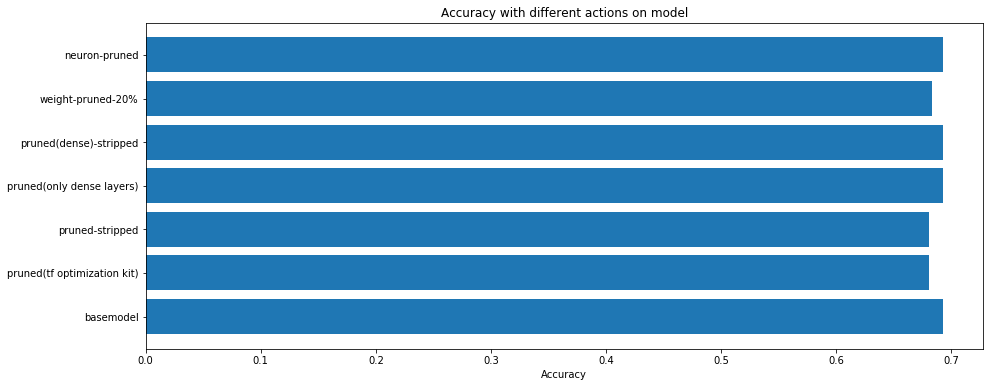

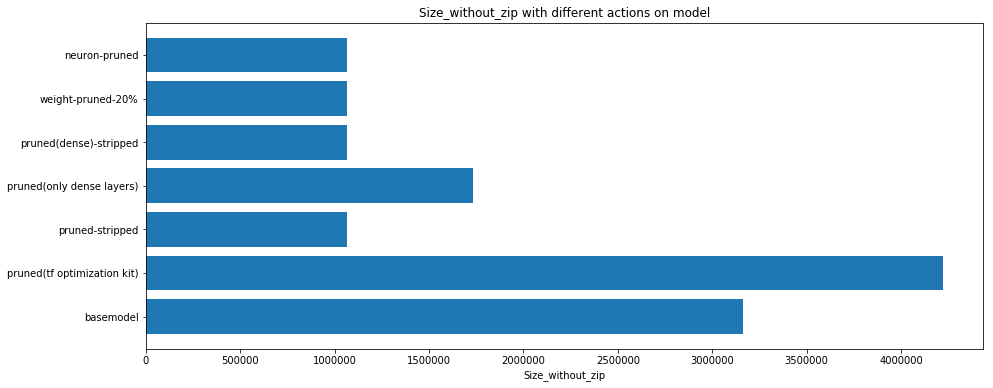

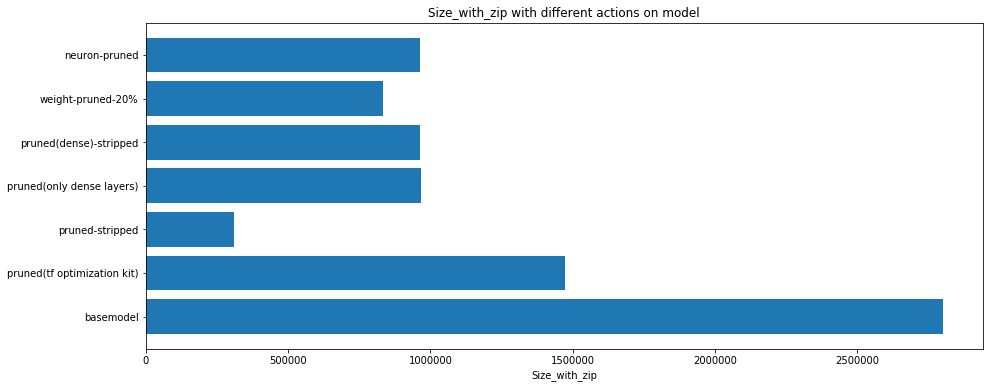

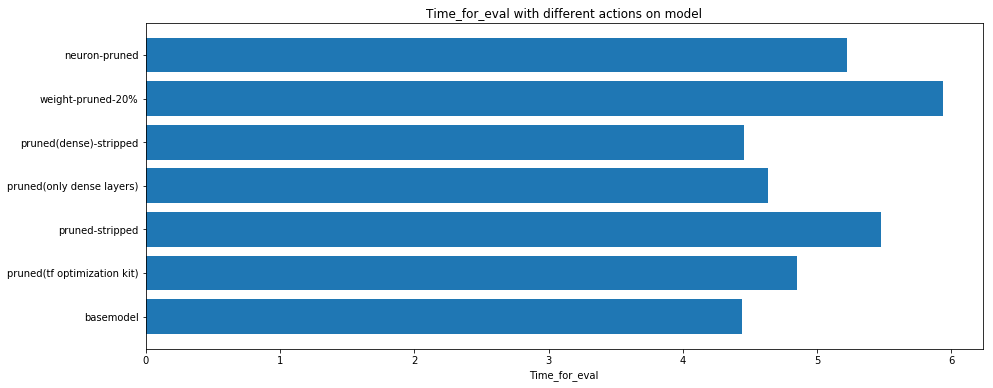

In [122]:
plotting_result('Accuracy')
plotting_result('Size_without_zip')
plotting_result('Size_with_zip')
plotting_result('Time_for_eval')